![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

## Destination Earth - Weather-Induced Extremes Digital Twin - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Documentation Digital Twin - Parameter Usage](https://confluence.ecmwf.int/display/DDCZ/DestinE+Parameter+Portfolios)

<br>Author: EUMETSAT</br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [1]:
import requests
import json
import os
from getpass import getpass
import dedl_authentication as deauth

In [6]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  csw-desp-user
Please input your DESP password:  ········


Response code: 200


### Query using the DEDL HDA API


### Filter
We have to setup up a filter and define which data to obtain.


In [8]:
datechoice = "2024-04-01T00:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "class": "rd",             # fixed (rd or d1)
        "expver": "i7yv",          # fixed experiment version 
        "stream": "oper",          # fixed oper
        "step": "0",               # Forcast step hourly (1..96)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "param": "31"             # Surface Pressure parameter
    }.items()
}

## Make Data Request

In [10]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.ECMWF.DAT.DT_EXTREMES"],
    "datetime": datechoice,
    "query": filters
})

# Requests to EO.ECMWF.DAT.DT_EXTREMES always return a single item containing all the requested data
product = response.json()["features"][0]
product

{'type': 'Feature',
 'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/sar/v1.0.0/schema.json'],
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'collection': 'EO.ECMWF.DAT.DT_EXTREMES',
 'links': [{'rel': 'self',
   'title': 'DT_EXTREMES_20240401_20240401_0c4afc43f9951d4e2adf5cfbc2758b26640eebf6',
   'href': 'https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20240401_20240401_0c4afc43f9951d4e2adf5cfbc2758b26640eebf6?provider=polytope_lumi&_dc_qs=%257B%2522class%2522%253A%252B%2522rd%2522%252C%252B%2522date%2522%253A%252B%252220240401%2Fto%2F20240401%2522%252C%252B%2522expver%2522%253A%252B%2522i7yv%2522%252C%252B%2522levtype%2522%253A%252B%2522sfc%2522%252C%252B%2522param%2522%253A%252B31%252C%252B%2522step%2522%253A%252B0%252C%252B%2522stream%2522%253A%252B%2522oper%2522%252C%252B%2522time%2522%253A%252B0%252C%252B%2522type%2522%253A%252B%2522fc%2522%257D'},
  {'rel': 'root', 'href': 'https://hda.data.destination-

## Submission worked ? Once our product found, we download the data.

In [11]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    JSON(response.json(), expanded=True)
    

## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [12]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()

        
# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response.headers)
    raise Exception("Content-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
downloading c439267c-ee40-4c9d-b4a5-4c8dfc26f4ac.grib


100%|██████████| 78.9M/78.9M [00:01<00:00, 64.5MB/s]


## Render the sea ice coverage on a map

Lets plot the result file

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [ ]:
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import numpy as np

ds = xr.load_dataset(filename, engine="cfgrib")

ds

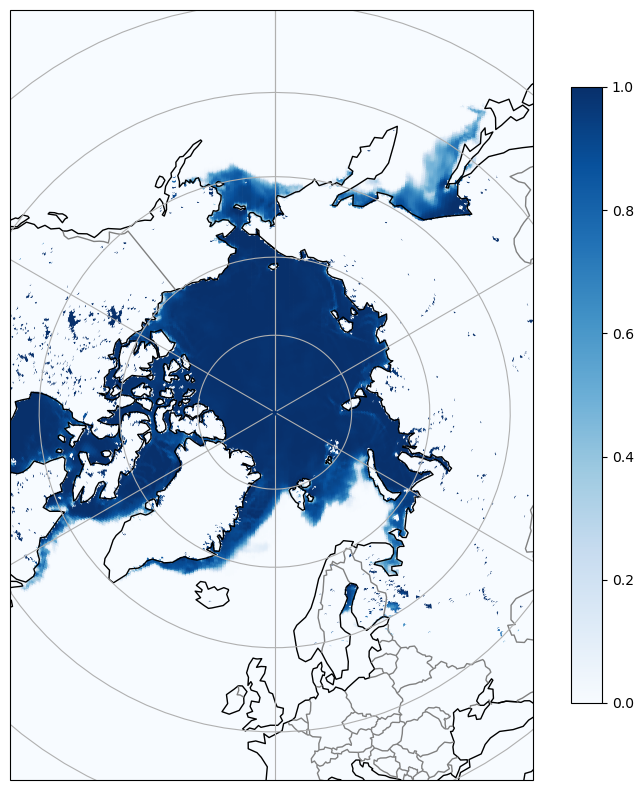

In [48]:
import cartopy.crs as crs
import cartopy.feature as cfeature

fig = plt.figure(figsize=[10, 10])

#ax = fig.add_subplot(1,1,1, projection=crs.Robinson())
crs_epsg=crs.NorthPolarStereo(central_longitude=0)
ax = fig.add_subplot(1,1,1, projection=crs_epsg)

ax.set_extent([-3850000.0, 3750000.0, -5350000, 5850000.0],crs_epsg)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, edgecolor="grey")
ax.gridlines()

cs = plt.scatter(x=ds.longitude[::10], y=ds.latitude.data[::10], c=ds.siconc[::10], cmap="Blues",
            s=1,
            transform=crs.PlateCarree())

fig.colorbar(cs, ax=ax, location='right', shrink =0.8)
plt.show()